# Reddit Sentiment Analysis

In [1]:
import pandas as pd

data = pd.read_csv("../input/cricket-on-reddit/reddit_cricket.csv")

print(data.shape)
data.head

(3905, 8)


<bound method NDFrame.head of         title  score       id  url  comms_num       created  \
0     Comment      1  haj030e  NaN          0  1.630047e+09   
1     Comment      5  haj02w5  NaN          0  1.630047e+09   
2     Comment      5  haj02qs  NaN          0  1.630047e+09   
3     Comment      2  haj01ky  NaN          0  1.630047e+09   
4     Comment      6  haj01cu  NaN          0  1.630047e+09   
...       ...    ...      ...  ...        ...           ...   
3900  Comment      1  hajfuvn  NaN          0  1.630060e+09   
3901  Comment      1  hajfu0w  NaN          0  1.630060e+09   
3902  Comment      1  hajftzx  NaN          0  1.630060e+09   
3903  Comment      1  hajftz1  NaN          0  1.630060e+09   
3904  Comment      1  hajftxn  NaN          0  1.630060e+09   

                                                   body            timestamp  
0     I'm scared he'll reach there in this series it...  2021-08-27 09:51:12  
1     Exactly lol people should stop seeing Jadeja a...

# Preprocess The Comments
When dealing with raw or uncleaned data, we would first have to preprocess or “clean” it before modelling or in our case, to apply a sentiment analysis.

In our instance, we would include the following steps for our preprocessing:
* Removing Emojis
* Tokenizing, removing links etc.
* Removing stopwords
* Normalizing words via lemmatizing

In [2]:
import emoji
import re

data['emojiless'] = data['body'].apply(lambda x: emoji.get_emoji_regexp().sub(u'', str(x)))
# data['emojiless']

In [3]:
from nltk.tokenize import RegexpTokenizer  
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+http\S+')
data['token'] = data['emojiless'].apply(lambda x: tokenizer.tokenize(x))
# print(data['token'])
data['lower_token'] = data['token'].apply(lambda x: [word.lower() for word in x])
# data['lower_token']

In [4]:
from nltk.corpus import stopwords
import en_core_web_sm
nlp = en_core_web_sm.load()
all_stopwords = nlp.Defaults.stop_words

data['token_without_sw'] = data['lower_token'].apply(lambda x: [word for word in x if not word in all_stopwords and len(word)>2 and not word in ["www", "http", "https", "reddit", "cricket", "nan"]])
# data['token_without_sw']

The last pre-processing step is one of **Lemmatizing** or **Stemming**.

Both processes are used to trim words down to their root words. However, stemming might return a root word that is not an actual word whereas, lemmatizing returns a root word that is an actual language word.

In [5]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

data['lemmatizer_tokens'] = data['token_without_sw'].apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
# print(data['lemmatizer_tokens'])

For visualization purposes, we can see that the number of words pre and post-processing has reduced dramatically!

In [6]:
print(f'Original number of words: ', sum([len(str(x)) for x in data['body']]))
print(f'Emojiless number of words: ', sum([len(str(x)) for x in data['emojiless']]))
print(f'Tokenized number of words: ', sum([len(str(x)) for x in data['lower_token']]))
print(f'Stopwordless number of words: ', sum([len(str(x)) for x in data['token_without_sw']]))
print(f'Lemmatized number of words: ', sum([len(str(x)) for x in data['lemmatizer_tokens']]))


Original number of words:  747507
Emojiless number of words:  746783
Tokenized number of words:  1093755
Stopwordless number of words:  625914
Lemmatized number of words:  617762


# Apply A Sentiment Analyzer (VADER)

Once we obtain our cleaned output, we would calculate each tokenized word's polarity scores using the **VADER** (Valence Aware Dictionary for Sentiment Reasoning) model.

The polarity scores measure the positivity and negativity for each word. We are mostly interested in the **compound score**, which is normalized to be between -1 (most extreme negative sentiment) and +1 (most extreme positive sentiment). This provides a single unidimensional measure of sentiment for a given word.

In [7]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import numpy as np

sia = SIA()
results = []

data['pool_score'] = data['lemmatizer_tokens'].apply(lambda x: [sia.polarity_scores(w).get('compound') for w in x]) 
# data['pool_score']
data['label'] = 0
data.loc[data['pool_score'].apply(lambda x: np.mean(x) > 0.1), 'label'] = 1
data.loc[data['pool_score'].apply(lambda x: np.mean(x) < 0.1), 'label'] = -1
# data['label']

/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


# Representation Of Sentiment Results

Using a quick value count, we can see that the sentiment for most of the words is nagative; they are also more positive than neutral in sentiment.

In [8]:
print(data.label.value_counts())

-1    2840
 0     600
 1     465
Name: label, dtype: int64


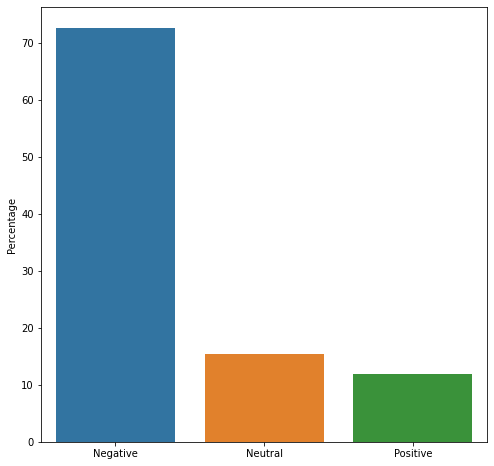

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,8))

counts = data.label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel('Percentage')

plt.show()

# Simple Visualizations

Lastly, before ending this post, we can perform some simple visualizations and explore the word frequency of positive and negative words.

Frequency distribution of the 20 most common positive words:

In [10]:
from nltk import FreqDist 

all_words = " ".join(x for x in data['lemmatizer_tokens'].apply(lambda x: " ".join(x))).split(" ")
positive_words = " ".join(x for x in data[data['label'] == 1]['lemmatizer_tokens'].apply(lambda x: " ".join(x))).split(" ")
negative_words = " ".join(x for x in data[data['label'] == -1]['lemmatizer_tokens'].apply(lambda x: " ".join(x))).split(" ")

pos_freq = FreqDist(positive_words).most_common(5)
neg_freq = FreqDist(negative_words).most_common(5)
print('pos_freq\n', pos_freq)
print('neg_freq\n', neg_freq)

pos_freq
 [('good', 49), ('best', 38), ('lol', 30), ('like', 28), ('win', 27)]
neg_freq
 [('com', 933), ('match', 649), ('india', 595), ('england', 510), ('run', 500)]


We can also visualize them via WordClouds.

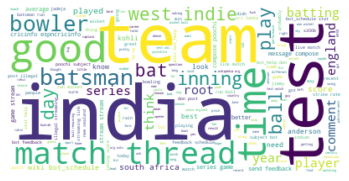

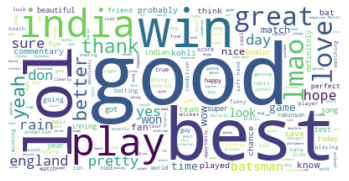

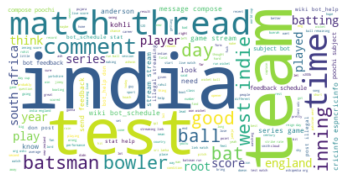

In [11]:
from wordcloud import WordCloud

wordcloud_total = WordCloud(background_color="white").generate(" , ".join(all_words))
wordcloud_posit = WordCloud(background_color="white").generate(" , ".join(positive_words))
wordcloud_negat = WordCloud(background_color="white").generate(" , ".join(negative_words))

plt.imshow(wordcloud_total, interpolation='bilinear')
plt.axis('off')
plt.show()

plt.imshow(wordcloud_posit, interpolation='bilinear')
plt.axis('off')
plt.show()

plt.imshow(wordcloud_negat, interpolation='bilinear')
plt.axis('off')
plt.show()